# **Exploratory Data Analysis (EDA) of PHEE Data**

Four aims during the EDA of the PHEE Data.

1. Description of data attributes
3. Distribution of Text Length
4. Word Cloud of Text to understand most prevalent topics in the raw text
5. Standardize the terms in the columns to provide statistics on the patient populations experiencing potentially detrimental effects. Non-standardized terms will be used to extract events. 
  - Distribution of drugs
  - Distribution of patient demographics
  - Median time elapsed until a side-effect appeared in a 
  patient
  - Median duration a patient is on a medication
  - The route with the most severe side-effects in elderly patients is ...
  - The top 4 therapy areas (Treat-Disorder) in the dataset ...

In [22]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
!pip install pharmpy
from pharmpy.epc import EPCEngine
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Load Data**

In [2]:
def pkl_load_dict(filename):
  """
    Load the dictionary data from a pickle file into a variable

    @P:
    filename (str): Name of the pkl file
    varname : Name of the df to save the pkl data

    @R:
    varname : Containing the pkl data
  """

  with open(filename, 'rb') as handle:
      df = pickle.load(handle)

  return df

df=pkl_load_dict('/content/drive/MyDrive/PHEE/output/data_df.pkl')

# **Description and Relationship of Select Medical/Data Terms**

**Subject** Patients involved in the medical event

Majority of the subjects are unknown (48%). The column should be preprocessed to group similar terms, like 'patient' and 'patients,' which may result in more meaningful data.

**Drug** A prescribed medication that causes a physiological effect 

The distribution of drugs in the dataset are uniform, with a slight majority of records with the drug 'methotrexate.' Unsure whether there is a mix of brand and generic drugs in the column.

**Adverse_event** Abbreviated as ADE. Denotes potentially harmful effects of medical therapies.

The most adverse event is 'induced.' Further grouping may be needed for the events.

**Effect** Indicates the outcome of the treatment.

There may be lots of overlap in terms, which may need to be normalized.

**Race** Indicates the subject’s race/nationality

Supporting the statistic that majority of the subject's are unknown, the majority of the race demographics are also unknown (92%). Standardization may be necessary.

**Age** Indicates the subject’s age

Supporting the statistic that majority of the subject's are unknown, the majority of the age demographics are also unknown (92%). Standardization of the ages is necessary. For example, '2-year-old child' and 'two' should be considered the same.

**Gender** Indicates the subject’s gender

Supporting the statistic that majority of the subject's are unknown, the majority of the age demographics are also unknown (82%). Standardization of the gender is necessary. For example, 'woman' and 'girl' should be considered the same.

**Text** Sentences extracted from biomedical literature, MEDLINE case reports, annotated with information
relevant to pharmacovigilance.


> **Ex** Diarrhoea, T-CD4+ lymphopenia and bilateral patchy pulmonary infiltrates developed in a male 60 yrs of age, who was treated with oxaliplatinum and 5-fluorouracil for unresectable rectum carcinoma.



In [3]:
def relative_freq(df,col):
  """
    Relective frequency of a column in a df

    @P:
      df (dataframe): Dataframe of data
      col (str): Name of the column of interest
    
  """
  return round(df[col].value_counts(normalize=True)*100,0).to_frame()

In [4]:
print("An example sentence extracted from a MEDLINE case report: \n {} \n".format(df['Text'].iloc[5]))
relative_freq(df,'Treat-Disorder')

An example sentence extracted from a MEDLINE case report: 
 Occasionally, despite good therapeutic response, clozapine must be stopped due to dangerous side effects such as agranulocytosis.
 



,Treat-Disorder
,63.0
High,4.0
rheumatoid arthritis,1.0
chronic hepatitis C,0.0
Crohn's disease,0.0
...,...
gastroesophageal reflux disease,0.0
necrotizing vasculitis,0.0
increasing pain in the joints||High,0.0
pre-excited atrial fibrillation,0.0


# **Distribution of Text Data Tokens**

**Distribution of Text Data Tokens** The text data contains text with a minimum number of tokens being 1 token and the maximum being 75 tokens. The median number of tokens is 17, while the average number of tokens is 18 tokens.

The statement with length of 1 token is:
"1."


In [5]:
def dist_text_len(df_rw,output_pth):
  """
    Save the distribution of the text length as a '.png' file 
    to the output path

    @P: 
      df_rw (dataframe): Dataframe of raw data
      output_pth (string): Path to save the '.png' file
  """
  dict_txt_dist={'text_lst':[],'txt_len_lst':[]}
  dict_txt_dist['text_lst']=df_rw['Text'].tolist()
  
  for txt in dict_txt_dist['text_lst']:
    txt_lst=txt.split()
    dict_txt_dist['txt_len_lst'].append(len(txt_lst))

  df=pd.DataFrame.from_dict(dict_txt_dist)
  sns.distplot(dict_txt_dist['txt_len_lst'], kde=False, color='blue', bins=10)
  plt.savefig(output_pth+'/text_len_dist.png')

  return df.describe()

def txt_by_len(dataframe,num):
  """
    Print text by length

    @P:
      dataframe (dataframe): contains the series with text data in the 
      'Text' column
      num (int): Number of tokens in target text
  """
  txt_lst=dataframe['Text'].to_list()
  
  for txt in txt_lst:
    txt_str_lst=txt.split(" ")

    if len(txt_str_lst)==num: print(txt,'\n')


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,txt_len_lst
count,4832.000000
mean,18.492550
std,9.242649
min,1.000000
25%,12.000000
50%,17.000000
75%,24.000000
max,75.000000


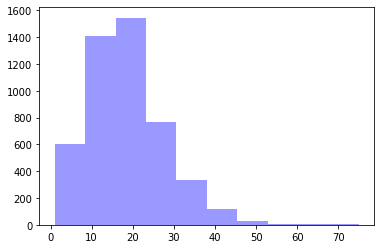

In [6]:
dist_text_len(df,'/content/drive/MyDrive/PHEE/output')

In [7]:
txt_by_len(df,1)

1.
 



# **Word Cloud of Text Data**

The most prevalent adeverse reaction in the text data is 'induced' and the most prevalent subject is 'patient.'

In [12]:
def word_cloud(dataframe,output_path):
  """
    Save a word cloud of text data

    @P:
    dataframe (dataframe): contains a column with text data in the 
      'Text' column
    output_path (string): Path to save the word cloud file

  """
  txt_clean_lst=[]
  txt_lst=dataframe['Text'].to_list()

  for f in txt_lst:
      f_lst=f.split(" ")
      for w in f_lst:
          txt_clean_lst.append(w.lower())

  txt_clean_lst_lower_str=" ".join(txt_clean_lst)

  stopwords = set(STOPWORDS)
  wordcloud=WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(txt_clean_lst_lower_str)
  wordcloud.to_file(output_path)

word_cloud(df,'/content/drive/MyDrive/PHEE/output/word_cloud.png')

# **Distribution of Drugs in the Dataset**

There are 2,312 unique items classified as 'Drugs' in the raw dataset. 

For this analysis, 'nan' is not considered a drug and items separed by double pipes, '||', are separated to make a more robust representation of the data. 

In [21]:
uniq_drug_lst_rw=list(set(df['Drug'].to_list()))

temp_lst=[]
for s in uniq_drug_lst_rw[0:10]:
  if s=='nan': print(s)
  s_remv_wt_space=s.strip()
  s_lower=s.lower()
  temp_lst.append(s_lower)

uniq_drug_lst_2=list(set(temp_lst))
print("There are {} unique items classified as 'Drugs' in the dataset \n\n".format(len(uniq_drug_lst_2)))

AttributeError: ignored